In [1]:
train_data = "/media/shreyas/DATA/ML_DATA/traffic_signs/train.p"
valid_data = "/media/shreyas/DATA/ML_DATA/traffic_signs/valid.p"
test_data = "/media/shreyas/DATA/ML_DATA/traffic_signs/test.p"
results = "/media/shreyas/DATA/ML_DATA/traffic_signs/results/"

In [25]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.backend import tf as k

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from utils import *
from vgg16 import Vgg16

In [3]:
# Load pickled data
import pickle

with open(train_data, mode='rb') as f:
    train = pickle.load(f)
with open(test_data, mode='rb') as f:
    test = pickle.load(f)
with open(valid_data, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

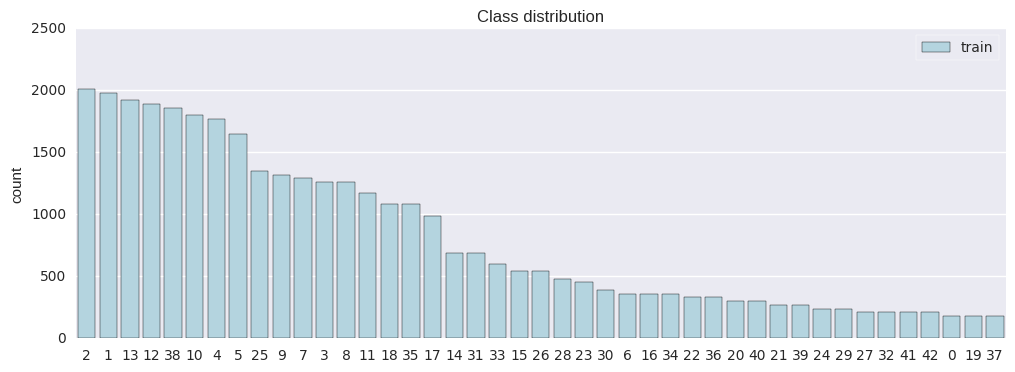

In [31]:
from collections import Counter
train_label_counter = Counter(y_train)

train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x=y_train, order=order, color='lightblue', ax=ax, label="train")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)

In [4]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'valid samples')
print(X_test.shape[0], 'test samples')

X_train shape: (34799, 32, 32, 3)
34799 train samples
4410 valid samples
12630 test samples


In [5]:
nb_train_samples = X_train.shape[0]
nb_valid_samples = X_valid.shape[0]
batch_size = 32
steps_per_epoch = nb_train_samples // batch_size
valid_steps = nb_valid_samples // batch_size

In [6]:
Y_train = np_utils.to_categorical(y_train, 43)
Y_valid = np_utils.to_categorical(y_valid, 43)
Y_test = np_utils.to_categorical(y_test, 43)

print (Y_train.shape)

(34799, 43)


## Image resizing

In [6]:
def image_resize(X, h, w):
    inp = Input(shape=(None, None, 3))
    out = Lambda(lambda image: k.image.resize_images(image, (h, w)))(inp)

    model = Model(input=inp, output=out)
    return model.predict(X)

In [7]:
X_trn299 = image_resize(X_train, 299, 299)
X_vld299 = image_resize(X_valid, 299, 299)

/home/shreyas/anaconda3/envs/wheelai/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=Tensor("in...)`


In [8]:
save_array(results + 'X_trn299.dat', X_trn299)
save_array(results + 'X_vld299.dat', X_vld299)

In [ ]:
X_trn299 = load_array(results + 'X_trn299.dat')
X_vld299 = load_array(results + 'X_vld299.dat')

In [8]:
print (X_trn299.shape, X_vld299.shape)

(34799, 299, 299, 3) (4410, 299, 299, 3)


## Feature Extraction

### VGG16

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
trn_ft = vgg.predict(X_trn224)
vld_ft = vgg.predict(X_vld224)

In [ ]:
print(trn_ft.shape, vld_ft.shape)

In [ ]:
save_array(results + 'trn_vgg.dat', trn_ft)
save_array(results + 'val_vgg.dat', vld_ft)

### ResNet50

In [57]:
res50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [58]:
res50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
trn_ft = res50.predict(X_trn224)
vld_ft = res50.predict(X_vld224)

In [62]:
save_array(results + 'trn_res.dat', trn_ft)
save_array(results + 'val_res.dat', vld_ft)

In [63]:
print(trn_ft.shape, vld_ft.shape)

(34799, 1, 1, 2048) (4410, 1, 1, 2048)


### Xception

In [11]:
xception = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))
xception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
trn_ft = xception.predict(X_trn299)
vld_ft = xception.predict(X_vld299)

In [ ]:
save_array(results + 'trn_xception.dat', trn_ft)
save_array(results + 'val_xception.dat', vld_ft)

In [ ]:
print(trn_ft.shape, vld_ft.shape)

## Vanila VGG

In [8]:
X_trn = load_array(results + 'trn_vgg.dat')
X_vld = load_array(results + 'val_vgg.dat')

In [9]:
print(X_trn.shape, X_vld.shape)

(34799, 7, 7, 512) (4410, 7, 7, 512)


In [11]:
inp = Input(shape=(X_trn.shape[1:]))
x = Flatten()(inp)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
ouput_layer = Dense(43, activation='softmax')(x)
model = Model(inputs=inp, outputs=ouput_layer)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=3, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/3
34799/34799 [==============================] - 6s - loss: 0.8421 - acc: 0.7719 - val_loss: 1.3683 - val_acc: 0.6435
Epoch 2/3
34799/34799 [==============================] - 4s - loss: 0.3034 - acc: 0.9071 - val_loss: 1.7592 - val_acc: 0.6274
Epoch 3/3
34799/34799 [==============================] - 4s - loss: 0.2472 - acc: 0.9237 - val_loss: 1.6421 - val_acc: 0.6755


In [13]:
model.optimizer.lr = 1e-5
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 4s - loss: 0.2065 - acc: 0.9349 - val_loss: 1.8986 - val_acc: 0.6857
Epoch 2/5
34799/34799 [==============================] - 4s - loss: 0.1886 - acc: 0.9430 - val_loss: 1.7470 - val_acc: 0.6902
Epoch 3/5
34799/34799 [==============================] - 4s - loss: 0.1755 - acc: 0.9458 - val_loss: 1.7338 - val_acc: 0.7136
Epoch 4/5
34799/34799 [==============================] - 4s - loss: 0.1719 - acc: 0.9493 - val_loss: 1.9411 - val_acc: 0.6880
Epoch 5/5
34799/34799 [==============================] - 4s - loss: 0.1540 - acc: 0.9532 - val_loss: 2.1819 - val_acc: 0.6902


In [14]:
model.optimizer.lr = 1e-3
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 4s - loss: 0.1564 - acc: 0.9532 - val_loss: 1.8765 - val_acc: 0.7270
Epoch 2/5
34799/34799 [==============================] - 4s - loss: 0.1453 - acc: 0.9566 - val_loss: 2.0802 - val_acc: 0.7136
Epoch 3/5
34799/34799 [==============================] - 4s - loss: 0.1334 - acc: 0.9599 - val_loss: 2.3624 - val_acc: 0.6961
Epoch 4/5
34799/34799 [==============================] - 4s - loss: 0.1469 - acc: 0.9595 - val_loss: 2.4665 - val_acc: 0.7116
Epoch 5/5
34799/34799 [==============================] - 4s - loss: 0.1375 - acc: 0.9602 - val_loss: 2.2115 - val_acc: 0.7172


In [15]:
model.optimizer.lr = 1e-5
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 4s - loss: 0.1369 - acc: 0.9610 - val_loss: 2.4147 - val_acc: 0.7120
Epoch 2/5
34799/34799 [==============================] - 4s - loss: 0.1309 - acc: 0.9619 - val_loss: 2.2834 - val_acc: 0.7193
Epoch 3/5
34799/34799 [==============================] - 4s - loss: 0.1222 - acc: 0.9659 - val_loss: 2.5302 - val_acc: 0.7197
Epoch 4/5
34799/34799 [==============================] - 4s - loss: 0.1192 - acc: 0.9656 - val_loss: 2.3415 - val_acc: 0.7181
Epoch 5/5
34799/34799 [==============================] - 4s - loss: 0.1206 - acc: 0.9664 - val_loss: 2.3875 - val_acc: 0.7299


In [16]:
model.optimizer.lr = 1e-3
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 4s - loss: 0.1158 - acc: 0.9663 - val_loss: 2.5337 - val_acc: 0.7029
Epoch 2/5
34799/34799 [==============================] - 4s - loss: 0.1161 - acc: 0.9681 - val_loss: 2.5439 - val_acc: 0.7181
Epoch 3/5
34799/34799 [==============================] - 4s - loss: 0.1126 - acc: 0.9686 - val_loss: 2.5697 - val_acc: 0.7154
Epoch 4/5
34799/34799 [==============================] - 4s - loss: 0.1214 - acc: 0.9681 - val_loss: 2.7023 - val_acc: 0.7213
Epoch 5/5
34799/34799 [==============================] - 4s - loss: 0.1034 - acc: 0.9706 - val_loss: 2.6350 - val_acc: 0.7193


In [17]:
inp = Input(shape=(X_trn.shape[1:]))
x = Flatten()(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
ouput_layer = Dense(43, activation='softmax')(x)
model = Model(inputs=inp, outputs=ouput_layer)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=3, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/3
34799/34799 [==============================] - 5s - loss: 7.0149 - acc: 0.3919 - val_loss: 4.7352 - val_acc: 0.4882
Epoch 2/3
34799/34799 [==============================] - 5s - loss: 3.7009 - acc: 0.6104 - val_loss: 3.3275 - val_acc: 0.6304
Epoch 3/3
34799/34799 [==============================] - 5s - loss: 3.0076 - acc: 0.6649 - val_loss: 2.8912 - val_acc: 0.6732


In [19]:
model.optimizer.lr = 1e-5
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 5s - loss: 2.7675 - acc: 0.6842 - val_loss: 2.8245 - val_acc: 0.6594
Epoch 2/5
34799/34799 [==============================] - 5s - loss: 2.6732 - acc: 0.6934 - val_loss: 2.7684 - val_acc: 0.6730
Epoch 3/5
34799/34799 [==============================] - 5s - loss: 2.6245 - acc: 0.7026 - val_loss: 2.7480 - val_acc: 0.6512
Epoch 4/5
34799/34799 [==============================] - 5s - loss: 2.5896 - acc: 0.7113 - val_loss: 2.7650 - val_acc: 0.6744
Epoch 5/5
34799/34799 [==============================] - 5s - loss: 2.5403 - acc: 0.7208 - val_loss: 2.6649 - val_acc: 0.6626


In [20]:
model.optimizer.lr = 1e-3
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 5s - loss: 2.5199 - acc: 0.7257 - val_loss: 2.6433 - val_acc: 0.6828
Epoch 2/5
34799/34799 [==============================] - 5s - loss: 2.4718 - acc: 0.7364 - val_loss: 2.6386 - val_acc: 0.6868
Epoch 3/5
34799/34799 [==============================] - 5s - loss: 2.4640 - acc: 0.7407 - val_loss: 2.5006 - val_acc: 0.7043
Epoch 4/5
34799/34799 [==============================] - 5s - loss: 2.4625 - acc: 0.7413 - val_loss: 2.6867 - val_acc: 0.6884
Epoch 5/5
34799/34799 [==============================] - 5s - loss: 2.4257 - acc: 0.7534 - val_loss: 2.6195 - val_acc: 0.7143


In [21]:
model.optimizer.lr = 1e-5
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 5s - loss: 2.4099 - acc: 0.7590 - val_loss: 2.6108 - val_acc: 0.6950
Epoch 2/5
34799/34799 [==============================] - 5s - loss: 2.3469 - acc: 0.7673 - val_loss: 2.6158 - val_acc: 0.7048
Epoch 3/5
34799/34799 [==============================] - 5s - loss: 2.3802 - acc: 0.7667 - val_loss: 2.4896 - val_acc: 0.7200
Epoch 4/5
34799/34799 [==============================] - 5s - loss: 2.3390 - acc: 0.7714 - val_loss: 2.4851 - val_acc: 0.7234
Epoch 5/5
34799/34799 [==============================] - 5s - loss: 2.3320 - acc: 0.7742 - val_loss: 2.4670 - val_acc: 0.7261


In [22]:
model.optimizer.lr = 1e-3
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 5s - loss: 2.2901 - acc: 0.7808 - val_loss: 2.4400 - val_acc: 0.7163
Epoch 2/5
34799/34799 [==============================] - 5s - loss: 2.2807 - acc: 0.7802 - val_loss: 2.3538 - val_acc: 0.7329
Epoch 3/5
34799/34799 [==============================] - 5s - loss: 2.2128 - acc: 0.7833 - val_loss: 2.3306 - val_acc: 0.7134
Epoch 4/5
34799/34799 [==============================] - 5s - loss: 2.2413 - acc: 0.7848 - val_loss: 2.4555 - val_acc: 0.7261
Epoch 5/5
34799/34799 [==============================] - 5s - loss: 2.1991 - acc: 0.7901 - val_loss: 2.2570 - val_acc: 0.7678


In [32]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg.summary()
#for layer in vgg.layers[:15]: layer.trainable=False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [36]:
layers = vgg.layers
maxpool_idx = [index for index,layer in enumerate(layers) if type(layer) is MaxPooling2D][-2]
print(maxpool_idx)

14


In [37]:
for layer in layers[:maxpool_idx+1]: layer.trainable = False

In [38]:
vgg_ft = Sequential(layers)

In [39]:
vgg_ft.add(model)

In [40]:
vgg_ft.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Vanilla ResNet50

In [6]:
X_trn = load_array(results + 'trn_res.dat')
X_vld = load_array(results + 'val_res.dat')

In [7]:
print(X_trn.shape, X_vld.shape)

(34799, 1, 1, 2048) (4410, 1, 1, 2048)


In [11]:
model = Sequential()
model.add(Conv2D(43, (3,3), padding='same', input_shape = X_trn.shape[1:]))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=X_trn, y=Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_vld, Y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 2s - loss: 3.4724 - acc: 0.0689 - val_loss: 3.5272 - val_acc: 0.0823
Epoch 2/20
34799/34799 [==============================] - 0s - loss: 3.4148 - acc: 0.0883 - val_loss: 3.4869 - val_acc: 0.0791
Epoch 3/20
34799/34799 [==============================] - 0s - loss: 3.3726 - acc: 0.0942 - val_loss: 3.4686 - val_acc: 0.0889
Epoch 4/20
34799/34799 [==============================] - 0s - loss: 3.3385 - acc: 0.1070 - val_loss: 3.4676 - val_acc: 0.1082
Epoch 5/20
34799/34799 [==============================] - 0s - loss: 3.3089 - acc: 0.1201 - val_loss: 3.4331 - val_acc: 0.1388
Epoch 6/20
34799/34799 [==============================] - 0s - loss: 3.2801 - acc: 0.1339 - val_loss: 3.4242 - val_acc: 0.1027
Epoch 7/20
34799/34799 [==============================] - 0s - loss: 3.2571 - acc: 0.1385 - val_loss: 3.4097 - val_acc: 0.1070
Epoch 8/20
34799/34799 [==============================] - 0s -